## 퍼실님께
8-8이전, 8-7까지는 거의 복붙이라 변경 사항이 없으니 그냥 넘어가셔도 됩니다

## 8-1. 들어가며

이번 시간에는 object detection 모델을 통해 주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어 보겠습니다. 하지만 자율주행 시스템은 아직 완전하지 않기 때문에, 위험한 상황에서는 운전자가 직접 운전할 수 있도록 하거나 판단이 어려운 상황에서는 멈추도록 설계됩니다. 우리도 같은 구조를 가진 미니 자율주행 시스템을 만들어 볼 겁니다.

먼저 전체적인 시스템을 구성하기 위해서 보조장치의 역할과 이를 학습하기 위한 데이터셋 전처리를 수행하겠습니다. Detection 모델을 학습시키기 위한 전체 파이프라인을 직접 제작하기에는 많은 시간이 들기 때문에 RetinaNet이라는 1-stage detector를 미리 학습시킨 라이브러리를 활용하도록 하겠습니다.

    주의: 이번 노드는 학습데이터 다운로드에 시간이 매우 오래 걸립니다. 학습하실 때 적절히 시간을 분배해 주세요.

실습 목표

    바운딩 박스(bounding box) 데이터셋을 전처리할 수 있습니다.
    Object detection 모델을 학습할 수 있습니다.
    Detection 모델을 활용한 시스템을 만들 수 있습니다.

학습 내용

    자율주행 보조장치
    RetinaNet
    keras-retinanet
    프로젝트: 자율주행 보조 시스템 만들기

준비물

아직 경로를 생성하지 않았다면 터미널을 열고 개인 실습 환경에 따라 경로를 수정, 프로젝트를 위한 디렉토리를 생성해 주세요.

$ mkdir -p ~/aiffel/object_detection/data

(주의) RetinaNet 홈페이지에 보면 tensorflow 2.3.0, tf.keras 2.4.0을 사용할 것을 권장하며, 그보다 높은 버전에서는 오류가 발생한다고 안내하고 있습니다.

우선은 본 노드를 돌려보실 때는 에러가 뜨지 않지만, 혹시라도 개인 프로젝트 진행 시 오류가 뜬다면 aiffel 가상환경에 설치된 Tensorflow 버전을 2.3.0에 맞추어 재설치하여 진행해주시길 바랍니다.

$ pip uninstall tensorflow
$ pip install tensorflow==2.3.0

프로젝트 디렉토리로 이동합니다. 그 후 다음 리포지토리(repository)를 받고, 리포지토리 사용에 필요한 케라스 라이브러리를 aiffel 가상환경 내에 설치해 줍니다.

$ cd ~/aiffel/object_detection
$ git clone https://github.com/fizyr/keras-retinanet.git
$ cd keras-retinanet && python setup.py build_ext --inplace

필요사항을 설치하고, keras-retinanet 또한 pip 패키지로 인스톨 해줍니다.

$ pip install -r requirements.txt
$ pip install .

In [1]:
# mkdir -p ~/aiffel/object_detection/data

# cd ~/aiffel/object_detection
# git clone https://github.com/fizyr/keras-retinanet.git
# cd keras-retinanet && python setup.py build_ext --inplace

# pip install -r requirements.txt
# pip install .

## 8-2. 자율주행 보조장치 (1) KITTI 데이터셋

이번 시간에 만들어 볼 자율주행 보조장치는 카메라에 사람이 가까워졌을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 이상일 때 멈춰야 합니다.

    자율주행 보조장치 object detection 요구사항

        1) 사람이 카메라에 감지되면 정지
        2) 차량이 일정 크기 이상으로 감지되면 정지

이번 시간에는 tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용해보겠습니다. KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.

[cvlibs에서 제공하는 KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)

먼저 필요한 라이브러리를 불러 오겠습니다.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

print('=3')

=3


In [3]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
#와 너무 오래 걸리네요
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print('=3')

=3


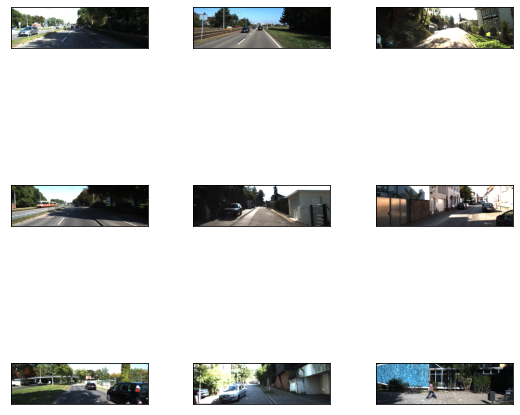

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 ds_info에서는 불러온 데이터셋의 정보를 확인할 수 있습니다. 오늘 사용할 데이터셋은 6,347개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다. 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있습니다.

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## 8-3 자율주행 보조장치 (2) 데이터 직접 확인하기
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 TakeDataset을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

------Example------
['image', 'image/file_name', 'objects']
003468.png 

------objects------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.82], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.42992   , 0.7561353 , 0.52930665, 0.847971  ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.62, 1.72, 4.35]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[17.91,  1.82, 33.66]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.34], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


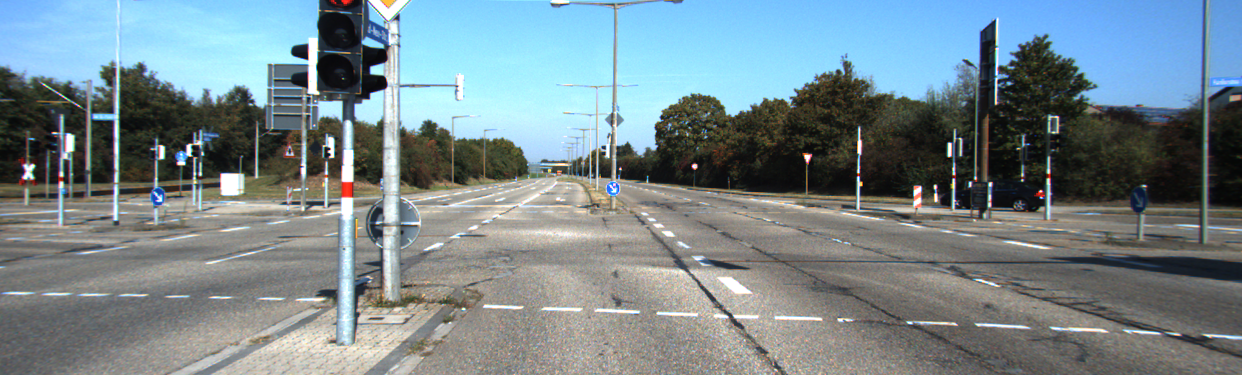

In [6]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    print(f'{filename} \n')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

이미지와 라벨을 얻는 방법을 알게 되었습니다. 그렇다면 이렇게 얻은 이미지의 바운딩 박스(bounding box, bbox)를 확인하기 위해서는 어떻게 해야 할까요?

아래는 KITTI에서 제공하는 데이터셋에 대한 설명입니다.

데이터셋 이해를 위한 예시

Values|    Name|      Description
-|:-|:-
1  |  type|         Describes the type of object: 'Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc' or 'DontCare'
1|    truncated|    Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries
   1|    occluded|     Integer (0,1,2,3) indicating occlusion state:   0 = fully visible, 1 = partly occluded                     2 = largely occluded, 3 = unknown
   1 |   alpha      |  Observation angle of object, ranging [-pi..pi]
   4  |  bbox        | 2D bounding box of object in the image (0-based index):contains left, top, right, bottom pixel coordinates
   3   | dimensions  | 3D object dimensions: height, width, length (in meters)
   3   | location    | 3D object location x,y,z in camera coordinates (in meters)
   1   | rotation_y   |Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1   | score        |Only for results: Float, indicating confidence in detection, needed for p/r curves, higher is better.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-input.max-800x600.png)
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-sample.max-800x600.png)

위 설명과 예시 이미지를 참고하셔서 이미지 위에 바운딩 박스를 그려서 시각화해 보세요!

힌트: [Pillow 라이브러리의 ImageDraw 모듈](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)을 참고하세요.

width: 1242  height: 375
(1, 4)
[ 939.12     213.78    1053.18     176.51001]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F1F807CB190>


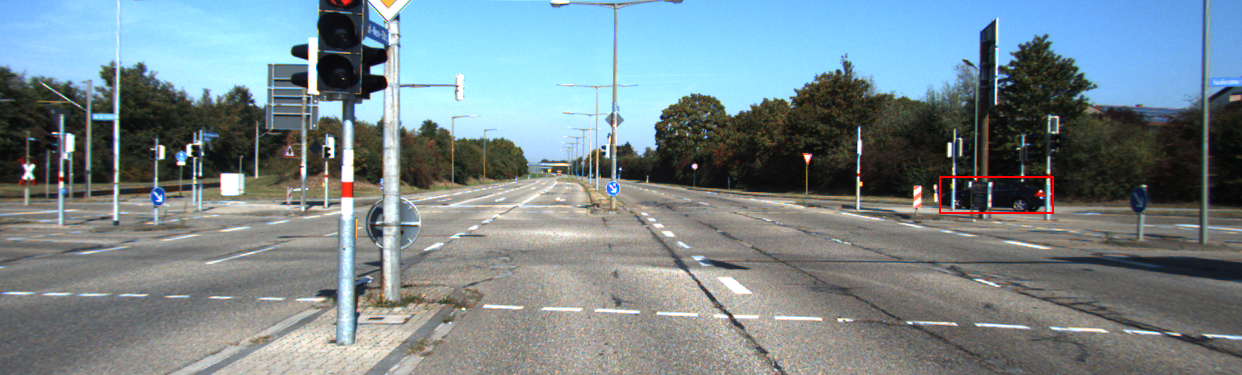

In [7]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 8-4. RetinaNet
>주요 참고 자료
>> - [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)  
>> - [김홍배님의 Focal loss의 응용(Detection & Classification)](https://www.slideshare.net/ssuser06e0c5/focal-loss-detection-classification)

RetinaNet은 Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델입니다. Detection 모델을 직접 만들기에는 많은 시간이 소요되기 때문에, 미리 모델을 구현한 라이브러리를 가져와 커스텀 데이터셋에 학습시키고 빠르게 사용해 보겠습니다.

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었습니다. 이를 해결하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용합니다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-car.max-800x600.png)

#### Focal Loss

Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다. 여기서 그리드(grid)와 픽셀(pixel)이 혼란스러울 수 있겠는데, 위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field입니다

그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 됩니다. 논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였습니다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/focal_loss.png)

Focal loss는 우리가 많이 사용해왔던 교차 엔트로피를 기반으로 만들어졌습니다. 위 그림을 보면 Focal loss는 그저 교차 엔트로피 CE(ptp_tpt​)의 앞단에 간단히 (1−pt)γ(1-p_t)^\gamma(1−pt​)γ 라는 modulating factor를 붙여주었습니다.

교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단되므로 손실이 줄어드는 것을 볼 수 있습니다. 하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어지는데요.

이 상황은 물체 검출 모델을 학습시키는 과정에서 문제가 될 수 있습니다. 대부분의 이미지에서는 물체보다 배경이 많습니다. 따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있습니다. 이렇게 너무 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해줍니다. 람다를 0으로 설정하면 modulating factor가 0이 되어 일반적인 교차 엔트로피가 되고 람다가 커질수록 modulating이 강하게 적용되는 것을 확인할 수 있습니다.
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-fpn.max-800x600.png)

#### FPN(Feature Pyramid Network)

FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식입니다. CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있습니다. 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있습니다. 이를 receptive field라고 합니다. 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 되는 것입니다.

FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있습니다. SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용했습니다. 레이어가 깊어질수록 feature map의 www,hhh방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적인 거죠.

[Upsampling 참고: CS231n - Lecture 11 | Detection and Segmentation](https://www.youtube.com/watch?v=nDPWywWRIRo)

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-FPN.max-800x600.png)

위 그림은 RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지를 설명하는 그림입니다. FPN은 각 level이 256채널로 이루어지는데, RetinaNet에서는 FPN의 P3P_3P3​부터 P7P_7P7​까지의 Pyramid level을 사용합니다. 이를 통해 Classification Subnet과 Box Regression Subnet 2개의 Subnet을 구성하게 되는데, Anchor 갯수를 AAA라고 하면 최종적으로 Classification Subnet은 KKK개 class에 대해 KAKAKA개 채널을, Box Regression Subnet은 4A4A4A개 채널을 사용하게 됩니다.

## 8-5. keras-retinanet 실습 (1) 데이터 포맷 변경

>주요 참고 자료
>> - [Keras RetinaNet](https://github.com/fizyr/keras-retinanet)

Keras RetinaNet은 케라스(Keras) 라이브러리로 구현된 RetinaNet입니다. 현재는 텐서플로우 2 버전을 지원하는 리포지토리(repository)도 만들어졌으나 아직 커스텀 데이터셋을 학습하는 방법을 공식 문서로 제시하지 않고 있습니다. 지금은 우선 Keras RetineNet 리포지토리를 이용해보도록 하겠습니다.

우리가 가진 tensorflow_dataset의 KITTI 데이터셋을 그대로 사용해서 Keras RetinaNet을 학습시키기 위해서는 라이브러리를 수정해야 합니다. 하지만 이보다 더 쉬운 방법은 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경해주는 방법입니다.
클래스 및 바운딩 박스 정보 추출

우리는 tensorflow_dataset의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있었습니다. 그렇다면 API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장해 봅시다.

한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성해 주세요. 우리가 생각하는 브레이크 시스템은 차와 사람을 구분해야 하는 점을 유의하시기 바랍니다.

데이터셋 포맷은 아래를 참고해 주세요.
```python
# 데이터셋 형식
path/to/image.jpg,x1,y1,x2,y2,class_name

# Example
/data/imgs/img_001.jpg,837,346,981,456,cow
/data/imgs/img_002.jpg,215,312,279,391,cat
/data/imgs/img_002.jpg,22,5,89,84,bird
/data/imgs/img_003.jpg,,,,,

CSV로 저장할 때는 아래 코드를 참고해 주세요.

# 데이터셋 저장 시 참고
df_test = parse_dataset(ds_test, total=ds_info.splits['test'].num_examples)
df_test.to_csv('원하는 폴더', sep=',', index=False, header=False)
```
tqdm은 루프문의 상태에 따라 콘솔에 진행 상황 바를 표시할 수 있는 라이브러리입니다. 자세한 사항은 리포지토리를 참고하세요.
  
> - [GitHub: tqdm](https://github.com/tqdm/tqdm)


In [8]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [25:02<00:00,  4.23it/s]


테스트 데이터셋에 대해서도 동일하게 parse_dataset() 을 적용해서 dataframe을 생성해 봅시다.

In [9]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:53<00:00,  4.09it/s]


#### 클래스 맵핑

데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 합니다. 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있습니다.

아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만들어 주세요.
```
class_name,id

#Example
cow,0
cat,1
bird,2
```

In [10]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


## 8-6. keras-retinanet 실습 (2) 셋팅

먼저 터미널을 열어주세요. 미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리를 사용하겠습니다.

아직 설치하지 않으셨다면, 0번 스텝의 '준비물' 항목을 참고하여 환경을 셋팅해 주세요.

준비가 완료되었다면 아래 스크립트를 참고하셔서 위에서 변환한 데이터셋으로 학습을 시작해 주세요. 학습이 잘 되기 위해서는 환경에 따라 batch_size나 worker, epoch를 조절해야 합니다.

훈련 이미지 크기 또는 batch_size가 너무 크면 GPU에서 out-of-memory 에러가 날 수 있으니 적절히 조정해 주세요. 원 개발자는 8G 메모리도 RetinaNet을 훈련시키기에는 부족할 수 있다고 설명합니다 (참고).

In [11]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-12-28 11:53:39.283409: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-28 11:53:41.342692: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-28 11:53:41.343842: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-28 11:53:41.369970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 11:53:41.370807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-12-28 11:53:41.370846: I tensorflow/stream_executor/platform/default/dso_lo

아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환합시다.

In [12]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-12-28 12:32:44.835945: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-28 12:32:46.611051: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-28 12:32:46.612146: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-28 12:32:46.619129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 12:32:46.619959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-12-28 12:32:46.620007: I tensorflow/stream_executor/platform/default/dso_lo

## 8-7. keras-retinanet 실습 (3) 시각화

이제 위에서 변환한 모델을 load하고 추론 및 시각화를 해보세요!

아래에 load된 모델을 통해 추론을 하고 시각화를 하는 함수를 작성해 주세요. 일정 점수 이하는 경우를 제거해야 함을 유의해 주세요.
[test_set.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/test_set.zip)

위 데이터는 이미 준비되었으니 연결만 하여 사용합시다.

In [13]:
# ! mkdir -p ~/aiffel/object_detection/test_set
# ! ln -s ~/data/*.png ~/aiffel/object_detection/test_set
#일주일 지나서해서 그런가 뭔가 정상작동안한다 심볼릭 링크 항상 문제다

In [14]:
# ! mkdir -p ~/aiffel/object_detection/test_set  

# ! wget https://d3s0tskafalll9.cloudfront.net/media/documents/test_set.zip  

# ! mv test_set.zip ~/aiffel/object_detection/test_set  

# ! cd ~/aiffel/object_detection/test_set && unzip test_set.zip  
#다운받아서 작업 폴더에 옮겨준다

In [15]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
#model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5') 
#자꾸에러나서 원인을 찾다가 변경해 보다가 다시 돌렸다
#다시 돌리니 잘된다 다시 돌리려고 중단시켰다가 다시 돌린게 뭔가 문제를 만든듯하다
#물론 내 3시간이 죽었다
model_path = os.getenv('HOME') + '/aiffel/object_detection/snapshots/resnet50_csv_10_infer.h5'
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[190.63199 136.89706 356.41568 228.58759]
[593.316   175.30702 626.4526  206.53537]
[371.7774  183.27904 418.23996 211.17258]
[529.62134 159.09523 564.6218  189.77583]
[440.55154 172.21408 474.56827 195.84175]


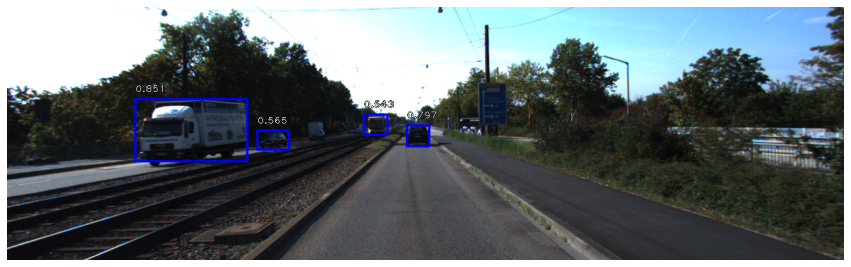

In [16]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

[768.64386 141.20349 852.7845  322.00238]
[726.16565 132.96992 880.478   331.6901 ]


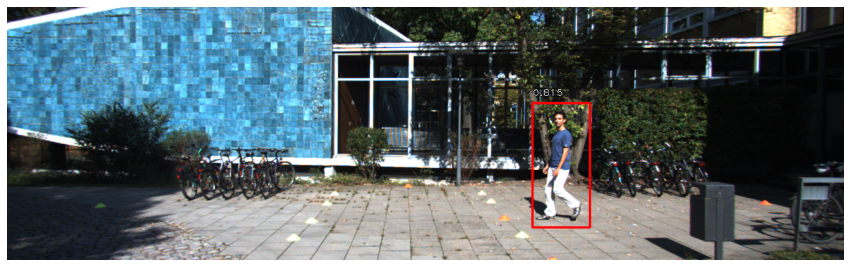

In [17]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

## 8-8. 프로젝트: 자율주행 보조 시스템 만들기
### 1. 자율주행 시스템 만들기

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

    입력으로 이미지 경로를 받습니다.
    정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
    조건은 다음과 같습니다.
        사람이 한 명 이상 있는 경우
        차량의 크기(width or height)가 300px이상인 경우

In [18]:
# img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

# def self_drive_assist(img_path, size_limit=300):
#     # 코드 구현
# 		# 정지조건에 맞으면 return "Stop"
# 		# 아닌 경우 return "Go"

# print(self_drive_assist(img_path))

In [22]:
#inference_on_image함수를 참조했다
def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
#         print(box)
        if score < 0.5:
            break
        if label: #label = "car" : 0, "person": 1 라벨이 1이면 사람이 있다
            return "Stop"
        elif label == 0: #라벨이 0 이면 차가 있다
            #차의 크기가 300이상이면 (주변의 차가 가까워서 크게 보이면) 멈춰라
            if abs(box[0]-box[2]) >= size_limit or abs(box[1]-box[3]) >= size_limit: ##box[0]= x1 box[2]= x2 box[1]= y1 box[3]= y2
                return "Stop"
    #둘다 아니면 go        
    return "Go"

Go
[190.63199 136.89706 356.41568 228.58759]
[593.316   175.30702 626.4526  206.53537]
[371.7774  183.27904 418.23996 211.17258]
[529.62134 159.09523 564.6218  189.77583]
[440.55154 172.21408 474.56827 195.84175]


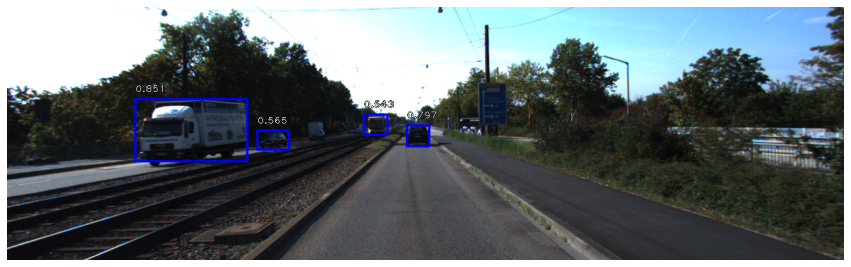

None


In [23]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'
print(self_drive_assist(img_path))
print(inference_on_image(model, img_path=img_path))

Go
[752.4466  162.14722 883.125   209.87431]
[  6.316559 206.21968  303.2094   369.12827 ]
[1005.2249   153.73239 1031.0981   220.35057]


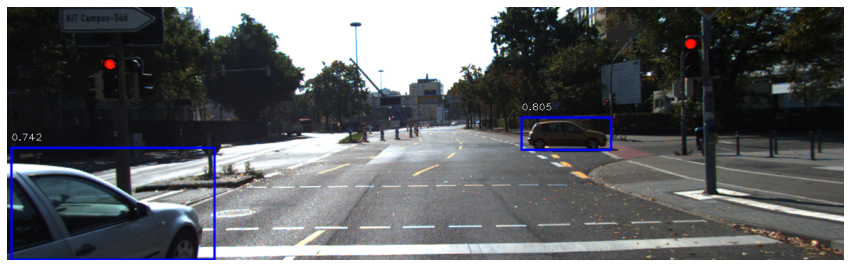

None


In [29]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_3.png'
print(self_drive_assist(img_path))
print(inference_on_image(model, img_path=img_path))
# 이게 go로 나와서 문제가 틀렸다는걸 알수있지만 
# 두번째 줄의 내가 지정해준 조건의 300이하는 아슬아슬하게 충족한다 
# 왜 0부터 안잡고 6부터 잡았을까

Go
[  0.95483464 190.04955    225.07663    312.52643   ]
[156.13911 181.9642  346.54898 253.30728]
[100.0805  188.55447 302.87555 264.1191 ]
[435.2933  176.1472  498.28024 209.2411 ]
[318.12976 176.1283  427.00793 221.29755]
[455.83984 177.33865 509.8443  205.02315]
[258.73837 178.65833 397.0221  230.06314]


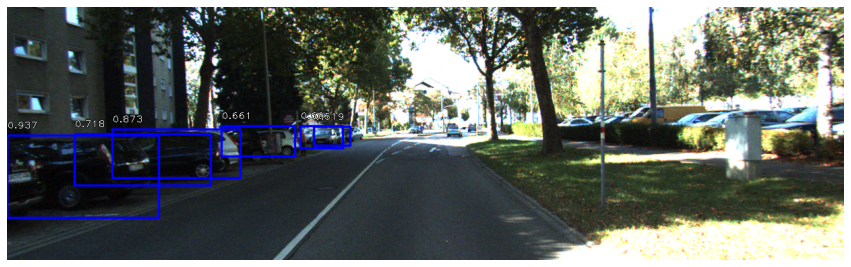

None


In [25]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_5.png'
print(self_drive_assist(img_path))
print(inference_on_image(model, img_path=img_path))
#여기는 잘 인식하는척 하지만 우측의 차들은 인식하지 못했다
# 차의 하체쪽이 가려지면 차로 인식을 못하는 듯 하다
#이걸 개선하려면 타이어 쪽은 배제하고 위쪽만 테스트 데이터 셋으로 주면
#가능할거라 추측된다 (혹은 일치율을 낮추던가)

### 2. 자율주행 시스템 평가하기

아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [24]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

90점입니다.


## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항|상세기준
:-|:-
1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.|	KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.
2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.|바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.
3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.|테스트 수행결과 90% 이상의 정확도를 보였다.

##  회고
1) 여러 시행착오를 겪었지만 당연히 되야할 load_model이 안되는거보고 원인을 찾기가 힘들었다. 이럴땐 단순하게 돌아가서 restart&run all (물론 여태 하던 내시간은 죽었다).   중간에도 추정했지만 정상작동 안하는 부분에서 정지시킨뒤에 다시 돌린게 원인인듯 하다

2) 음 몹시 실무에 가까워 보여서 재밌었다 하지만 라이다 센서도 그렇고 이 예시도 그렇고 굳이 한가지 수단으로만 완벽을 추구하지말고 앙상블 모델처럼 여러가지 교차검증으로 ( 초음파 거리 측정 , 레이저 거리측정, 영상처리 등) 오차율을 줄이려는 노력이 필요할거 같다.

3) 입력과 출력의 형태를 명확히 확인하고 시작하는것이 중요하다는걸 배운 챕터인거 같다

4) 이런 기술들을 통해서 더 자동화하고 더 편해지고 싶다